## Описание проекта

Постановка задачи
Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

* Оцените корректность проведения теста
* Проанализируйте результаты теста
Чтобы оценить корректность проведения теста, проверьте:
* пересечение тестовой аудитории с конкурирующим тестом,
* совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

**Техническое задание**
* Название теста: `recommender_system_test`;
* группы: А — контрольная, B — новая платёжная воронка;
* дата запуска: 2020-12-07;
* дата остановки набора новых пользователей: 2020-12-21;
* дата остановки: 2021-01-04;
* аудитория: 15% новых пользователей из региона EU;
* назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* ожидаемое количество участников теста: 6000.
* ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%: 
* * конверсии в просмотр карточек товаров — событие `product_page`,
* * просмотры корзины — `product_cart`,
* * покупки — `purchase`.

**Данные**
* `final_ab_events.csv`
* `final_ab_project_marketing_events.csv`
* `final_ab_new_users.csv`
* `final_ab_participants.csv`

**Описание данных**

* `ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:
* `name` — название маркетингового события;
* `regions` — регионы, в которых будет проводиться рекламная кампания;
* `start_dt` — дата начала кампании;
* `finish_dt` — дата завершения кампании.

* `final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:
* `user_id` — идентификатор пользователя;
* `first_date` — дата регистрации;
* `region` — регион пользователя;
* `device` — устройство, с которого происходила регистрация.


* `final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:
* `user_id` — идентификатор пользователя;
* `event_dt` — дата и время покупки;
* `event_name` — тип события;
* `details` — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

* `final_ab_participants.csv — таблица участников тестов.

Структура файла:
* `user_id` — идентификатор пользователя;
* `ab_test` — название теста;
* `group` — группа пользователя.


## Загрузка данных, первичный анализ данных

In [1]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import datetime as dt
from scipy import stats as st
#from scipy.stats import shapiro
# from itertools import combinations

import plotly.figure_factory as ff
from plotly import graph_objects as go

import warnings
warnings.filterwarnings('ignore')

###############################################
import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 1000
png_renderer.height = 1000
pio.renderers.default = "png"

In [2]:
# final_ab_events = pd.read_csv("/datasets/final_ab_events.csv")
# final_ab_marketing_events = pd.read_csv("/datasets/ab_project_marketing_events.csv")
# final_ab_new_users = pd.read_csv("/datasets/final_ab_new_users.csv")
# final_ab_participants = pd.read_csv("/datasets/final_ab_participants.csv")

final_ab_events = pd.read_csv("https://code.s3.yandex.net/datasets/final_ab_events.csv")
final_ab_marketing_events = pd.read_csv("https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv")
final_ab_new_users = pd.read_csv("https://code.s3.yandex.net/datasets/final_ab_new_users.csv")
final_ab_participants = pd.read_csv("https://code.s3.yandex.net/datasets/final_ab_participants.csv")

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 200)

In [3]:
dfs_dict = {'final_ab_events':final_ab_events, 'final_ab_marketing_events':final_ab_marketing_events, 'final_ab_new_users':final_ab_new_users, 'final_ab_participants':final_ab_participants}
for name_, df_ in dfs_dict.items():
    print('='*60)
    print('\033[1m'+f'    INFO {name_}'+'\033[0m', end='\n\n')
    print(df_.info(), end='\n\n')
    print('='*60)
    print('\033[1m'+f'Initial Duplicates in {name_}: '+'\033[0m', df_.duplicated().sum(), end='\n\n')
    if df_.duplicated().sum() > 0:
        df_.drop_duplicates(inplace=True)
        print('\033[1m'+f'Final Duplicates  in {name_}: '+'\033[0m', df_.duplicated().sum(), end='\n\n')
    print('='*60)
    df_.columns = df_.columns.str.lower().str.replace(' ', '_')
    print('\033[1m'+f'Columns in {name_}:'+'\033[0m\n', df_.columns)
    print('='*60)
    print('\033[1m'+f'Nulls and notNAs in {name_}:'+'\033[0m\n')
    missing_data = pd.DataFrame({'nulls':df_.isna().sum()})
    missing_data['null_rate'] = df_.isna().mean().map(lambda x: '{:.2%}'.format(x))
    missing_data['notna'] = df_.notna().sum()
    missing_data['notna_rate'] = df_.notna().mean().map(lambda x: '{:.2%}'.format(x))
    
    display(missing_data)
    
    print('='*60)
    print('\033[1m'+f'Number of properties in {name_}:'+'\033[0m\n', len(df_.columns))
    print('='*60)
    display(df_.head(3))
    print('='*60)

    INFO final_ab_events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None

Initial Duplicates in final_ab_events:  0

Columns in final_ab_events:
 Index(['user_id', 'event_dt', 'event_name', 'details'], dtype='object')
Nulls and notNAs in final_ab_events:



,nulls,null_rate,notna,notna_rate
user_id,0,0.00%,440317,100.00%
event_dt,0,0.00%,440317,100.00%
event_name,0,0.00%,440317,100.00%
details,377577,85.75%,62740,14.25%


Number of properties in final_ab_events:
 4


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99


    INFO final_ab_marketing_events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None

Initial Duplicates in final_ab_marketing_events:  0

Columns in final_ab_marketing_events:
 Index(['name', 'regions', 'start_dt', 'finish_dt'], dtype='object')
Nulls and notNAs in final_ab_marketing_events:



,nulls,null_rate,notna,notna_rate
name,0,0.00%,14,100.00%
regions,0,0.00%,14,100.00%
start_dt,0,0.00%,14,100.00%
finish_dt,0,0.00%,14,100.00%


Number of properties in final_ab_marketing_events:
 4


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19


    INFO final_ab_new_users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None

Initial Duplicates in final_ab_new_users:  0

Columns in final_ab_new_users:
 Index(['user_id', 'first_date', 'region', 'device'], dtype='object')
Nulls and notNAs in final_ab_new_users:



,nulls,null_rate,notna,notna_rate
user_id,0,0.00%,61733,100.00%
first_date,0,0.00%,61733,100.00%
region,0,0.00%,61733,100.00%
device,0,0.00%,61733,100.00%


Number of properties in final_ab_new_users:
 4


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC


    INFO final_ab_participants

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None

Initial Duplicates in final_ab_participants:  0

Columns in final_ab_participants:
 Index(['user_id', 'group', 'ab_test'], dtype='object')
Nulls and notNAs in final_ab_participants:



,nulls,null_rate,notna,notna_rate
user_id,0,0.00%,18268,100.00%
group,0,0.00%,18268,100.00%
ab_test,0,0.00%,18268,100.00%


Number of properties in final_ab_participants:
 3


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test


### **Вывод**
* Данные представлены в четырех файлах
* Данные заполнены все на 100%, кроме колонки "details" в файле `final_ab_events`. В данной колонке отсутствуют записи в кол-ве 62740, что составляет 85.75%, то есть уровень заполненности составляет 14.25%
* Дубликаты отсутствуют
* Названия колонок преобразованы в соответствии с требованиями ***snake_style***

## Предобработка данных
1. перевод временных колонок в формат datetime
2. заполнение пропусков

1. перевод временных колонок в формат datetime

In [4]:
# dfs = [final_ab_events, final_ab_marketing_events, final_ab_new_users, final_ab_participants]
for name, df_ in dfs_dict.items():
    display(name, df_.head(1))

'final_ab_events'

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99


'final_ab_marketing_events'

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


'final_ab_new_users'

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC


'final_ab_participants'

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test


In [5]:
for par in [final_ab_marketing_events.start_dt, final_ab_marketing_events.finish_dt, final_ab_new_users.first_date]:
        par = pd.to_datetime(par, format="%Y-%m-%d")
        
final_ab_events.event_dt = pd.to_datetime(final_ab_events.event_dt, format="%Y-%m-%d %H:%M:%S")

2. заполнение пропусков

In [6]:
final_ab_events.isna().mean()

user_id       0.000000
event_dt      0.000000
event_name    0.000000
details       0.857512
dtype: float64

In [7]:
final_ab_events.groupby('event_name').details.sum()

event_name
login                 0.0
product_cart          0.0
product_page          0.0
purchase        1498082.6
Name: details, dtype: float64

In [8]:
final_ab_events.fillna(0, inplace=True)  # замена
final_ab_events.isna().sum()             # проверка

user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

Заменим названия акций и регионов в соответствии с ***snake_style***

In [14]:
final_ab_marketing_events.name = final_ab_marketing_events.name.str.lower().str.replace(' ', '_')
final_ab_marketing_events.regions = final_ab_marketing_events.regions.str.lower().str.replace(' ', '_')
final_ab_new_users.region = final_ab_new_users.region.str.lower().str.replace(' ', '_')
final_ab_new_users.device = final_ab_new_users.device.str.lower().str.replace(' ', '_')

In [15]:
final_ab_marketing_events

,name,regions,start_dt,finish_dt
0,christmas&new_year_promo,"eu,_n.america",2020-12-25,2021-01-03
1,st._valentine's_day_giveaway,"eu,_cis,_apac,_n.america",2020-02-14,2020-02-16
2,st._patric's_day_promo,"eu,_n.america",2020-03-17,2020-03-19
3,easter_promo,"eu,_cis,_apac,_n.america",2020-04-12,2020-04-19
4,4th_of_july_promo,n.america,2020-07-04,2020-07-11
5,black_friday_ads_campaign,"eu,_cis,_apac,_n.america",2020-11-26,2020-12-01
6,chinese_new_year_promo,apac,2020-01-25,2020-02-07
7,labor_day_(may_1st)_ads_campaign,"eu,_cis,_apac",2020-05-01,2020-05-03
8,international_women's_day_promo,"eu,_cis,_apac",2020-03-08,2020-03-10
9,victory_day_cis_(may_9th)_event,cis,2020-05-09,2020-05-11


### **Вывод**
* даты и временные отметки переведены в во временной формат
* пропуски заменены на `0`

## Исследовательский анализ

Проверим даты регистрации новых пользователей

In [16]:
print("Начало регистрации новых пользователей: ", final_ab_new_users.first_date.min())
print("Конец регистрации новых пользователей: ", final_ab_new_users.first_date.max())

Начало регистрации новых пользователей:  2020-12-07
Конец регистрации новых пользователей:  2020-12-23


Фактическая дата остановки регистрации новых пользователей не соответствуюет техническому заданию (2020-12-21)

Отфильтруем пользователей, не соответствующих техническому заданию

In [17]:
final_ab_new_users = final_ab_new_users.query('first_date < "2020-12-21"')

In [18]:
print(final_ab_new_users.shape)
final_ab_new_users.user_id.nunique()

(50180, 4)


50180

Все пользователи уникальны

In [19]:
reg_users = final_ab_new_users.groupby('region', as_index=False).user_id.nunique()
reg_users['reg_share'] = (reg_users.user_id / reg_users.user_id.sum()).map(lambda x: '{:.2%}'.format(x))
reg_users

,region,user_id,reg_share
0,apac,2551,5.08%
1,cis,2530,5.04%
2,eu,37690,75.11%
3,n.america,7409,14.76%


Общий набор событий из Европы состоялся в кол-ве 37690 (75.11%)

Будем ориентироваться на проведенный тест по привлечению новых клиентов

Рассмотрим пользователей в группах А и В

In [20]:
display(final_ab_participants.groupby('group', as_index=False).user_id.count())   # кол-во событий в каждой из групп

,group,user_id
0,A,9655
1,B,8613


In [21]:
both_groups_users = set(final_ab_participants.query('group == "A"').user_id) \
                    & set(final_ab_participants.query('group == "B"').user_id)
print("Кол-во событий для групп А и В в пересечении обоих групп: ", len(both_groups_users))
print("Кол-во записей: ", len(final_ab_participants))
print("Кол-во пользоваителей в тесте: ", final_ab_participants.user_id.nunique())

ab_interception = final_ab_participants.groupby('user_id').user_id.count() \
    .to_frame() \
    .rename(columns = {'user_id':'id_count'}) \
    .sort_values('id_count', ascending=False).query('id_count > 1')
print("Кол-во пользователей, совершивших более одного действия: ", len(ab_interception))

Кол-во событий для групп А и В в пересечении обоих групп:  776
Кол-во записей:  18268
Кол-во пользоваителей в тесте:  16666
Кол-во пользователей, совершивших более одного действия:  1602


Точно неизвестно, по какой причине пользователи из одной группы отмечены, как и участники другой. Поэтому исключить участников пересечения только из одной группы нельзя, иначе будет внесена неопределенность именно из-за неизвестности причины попадания в пересечение и такое решение может внести искажение в результат исследования. В связи с этим логично исключение участников пересечения из обеих групп.

In [22]:
final_participants = final_ab_participants.query(f'user_id not in {list(both_groups_users)} \
    & ab_test == "recommender_system_test"')
display(final_participants.groupby('group', as_index=False).user_id.nunique())
final_participants.head(2)

,group,user_id
0,A,3385
1,B,2540


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test


Получим данные о событиях, относящихся к пользователям из АВ теста, а также их кол-во

In [23]:
# events_ab = final_ab_events.merge(final_participants, how = 'inner', on = 'user_id')
# display(events_ab.groupby('group',as_index=False).user_id.nunique()) # Кол-во пользователей в группах
# display(events_ab.head(2))

In [24]:
events_ab = final_ab_events.merge(final_participants, how = 'right', on = 'user_id')
groups = events_ab.groupby('group',as_index=False).user_id.nunique()
display(groups) # Кол-во пользователей в группах
# events_ab['perc'] = events_ab.at[0,'user_id']
groups['perc'] = (groups.user_id / groups.user_id.sum()).map(lambda x: '{:.2%}'.format(x))
display(groups)
display(events_ab.head(2))

,group,user_id
0,A,3385
1,B,2540


,group,user_id,perc
0,A,3385,57.13%
1,B,2540,42.87%


,user_id,event_dt,event_name,details,group,ab_test
0,D1ABA3E2887B6A73,2020-12-07 14:43:27,purchase,99.99,A,recommender_system_test
1,D1ABA3E2887B6A73,2020-12-25 00:04:56,purchase,4.99,A,recommender_system_test


***Хотя доли и неравны, но ближе к 50/50, чем к 75/25***

Общее кол-во уже меньше 6.000

Распределение по регионам рассмотрим чуть позже

Теперь проверим, есть ли пересечение по времени проведения АВ теста с временем проведения маркетинговых акций (исключение периодов перекрестных активностей)

In [25]:
ab_min_time = events_ab.event_dt.min()   # начало теста
ab_max_time = events_ab.event_dt.max()   # конец теста
print('Продолжительность проведения теста: ', ab_max_time - ab_min_time)

Продолжительность проведения теста:  23 days 06:26:52


In [26]:
# оработка названий акций, регионов, получение продолжительности акций в днях
marketing_act = final_ab_marketing_events.groupby(['name','regions'], as_index=False).agg({'start_dt':'min', 'finish_dt':'max'})
marketing_act.start_dt = pd.to_datetime(marketing_act.start_dt, format="%Y-%m-%d")
marketing_act.finish_dt = pd.to_datetime(marketing_act.finish_dt, format="%Y-%m-%d")
marketing_act['duration'] = marketing_act.finish_dt - marketing_act.start_dt
display(marketing_act.sort_values('finish_dt', ascending=False))
print("Кол-во повторений в списке маркетинговый акций: ", marketing_act.name.duplicated().sum())

,name,regions,start_dt,finish_dt,duration
5,cis_new_year_gift_lottery,cis,2020-12-30,2021-01-07,8 days
4,christmas&new_year_promo,"eu,_n.america",2020-12-25,2021-01-03,9 days
1,black_friday_ads_campaign,"eu,_cis,_apac,_n.america",2020-11-26,2020-12-01,5 days
10,single's_day_gift_promo,apac,2020-11-11,2020-11-12,1 days
2,chinese_moon_festival,apac,2020-10-01,2020-10-07,6 days
0,4th_of_july_promo,n.america,2020-07-04,2020-07-11,7 days
6,dragon_boat_festival_giveaway,apac,2020-06-25,2020-07-01,6 days
13,victory_day_cis_(may_9th)_event,cis,2020-05-09,2020-05-11,2 days
9,labor_day_(may_1st)_ads_campaign,"eu,_cis,_apac",2020-05-01,2020-05-03,2 days
7,easter_promo,"eu,_cis,_apac,_n.america",2020-04-12,2020-04-19,7 days


Кол-во повторений в списке маркетинговый акций:  0


In [27]:
# marketing_act.name = marketing_act.name.replace(["4th_of_july_promo", "victory_day_cis_(may_9th)_event"], ['fourth_of_july_promo','victory_day_cis_(may_nineth)_event'])
marketing_act['event_date_beg'] = events_ab.event_dt.min()
marketing_act['event_date_end'] = events_ab.event_dt.max()

marketing_act['event_start'] = marketing_act.event_date_beg.dt.date
marketing_act['event_start_t'] = pd.to_datetime(marketing_act.event_start, format='%Y-%m-%d')
marketing_act = marketing_act.drop(columns = ['event_start','event_date_beg'], axis=1)

marketing_act['event_end'] = marketing_act.event_date_end.dt.date
marketing_act['event_end_t'] = pd.to_datetime(marketing_act.event_end, format='%Y-%m-%d')
marketing_act = marketing_act.drop(columns = ['event_end','event_date_end'], axis=1)

marketing_act

,name,regions,start_dt,finish_dt,duration,event_start_t,event_end_t
0,4th_of_july_promo,n.america,2020-07-04,2020-07-11,7 days,2020-12-07,2020-12-30
1,black_friday_ads_campaign,"eu,_cis,_apac,_n.america",2020-11-26,2020-12-01,5 days,2020-12-07,2020-12-30
2,chinese_moon_festival,apac,2020-10-01,2020-10-07,6 days,2020-12-07,2020-12-30
3,chinese_new_year_promo,apac,2020-01-25,2020-02-07,13 days,2020-12-07,2020-12-30
4,christmas&new_year_promo,"eu,_n.america",2020-12-25,2021-01-03,9 days,2020-12-07,2020-12-30
5,cis_new_year_gift_lottery,cis,2020-12-30,2021-01-07,8 days,2020-12-07,2020-12-30
6,dragon_boat_festival_giveaway,apac,2020-06-25,2020-07-01,6 days,2020-12-07,2020-12-30
7,easter_promo,"eu,_cis,_apac,_n.america",2020-04-12,2020-04-19,7 days,2020-12-07,2020-12-30
8,international_women's_day_promo,"eu,_cis,_apac",2020-03-08,2020-03-10,2 days,2020-12-07,2020-12-30
9,labor_day_(may_1st)_ads_campaign,"eu,_cis,_apac",2020-05-01,2020-05-03,2 days,2020-12-07,2020-12-30


In [28]:
marketing_act = marketing_act.rename(columns = {'start_dt':'promo_start', 'finish_dt':'promo_end', 'event_start_t':'ab_start', 'event_end_t':'ab_end'})
marketing_act['length'] = marketing_act.ab_end - marketing_act.ab_start
marketing_act['dur_days_int'] = pd.to_numeric(marketing_act.duration.dt.days, downcast='integer') # длительености как число
marketing_act

,name,regions,promo_start,promo_end,duration,ab_start,ab_end,length,dur_days_int
0,4th_of_july_promo,n.america,2020-07-04,2020-07-11,7 days,2020-12-07,2020-12-30,23 days,7
1,black_friday_ads_campaign,"eu,_cis,_apac,_n.america",2020-11-26,2020-12-01,5 days,2020-12-07,2020-12-30,23 days,5
2,chinese_moon_festival,apac,2020-10-01,2020-10-07,6 days,2020-12-07,2020-12-30,23 days,6
3,chinese_new_year_promo,apac,2020-01-25,2020-02-07,13 days,2020-12-07,2020-12-30,23 days,13
4,christmas&new_year_promo,"eu,_n.america",2020-12-25,2021-01-03,9 days,2020-12-07,2020-12-30,23 days,9
5,cis_new_year_gift_lottery,cis,2020-12-30,2021-01-07,8 days,2020-12-07,2020-12-30,23 days,8
6,dragon_boat_festival_giveaway,apac,2020-06-25,2020-07-01,6 days,2020-12-07,2020-12-30,23 days,6
7,easter_promo,"eu,_cis,_apac,_n.america",2020-04-12,2020-04-19,7 days,2020-12-07,2020-12-30,23 days,7
8,international_women's_day_promo,"eu,_cis,_apac",2020-03-08,2020-03-10,2 days,2020-12-07,2020-12-30,23 days,2
9,labor_day_(may_1st)_ads_campaign,"eu,_cis,_apac",2020-05-01,2020-05-03,2 days,2020-12-07,2020-12-30,23 days,2


Рассмотрим наглядно, как выглядять промо- и маркетинговые акции во времени на диаграмме Ганта

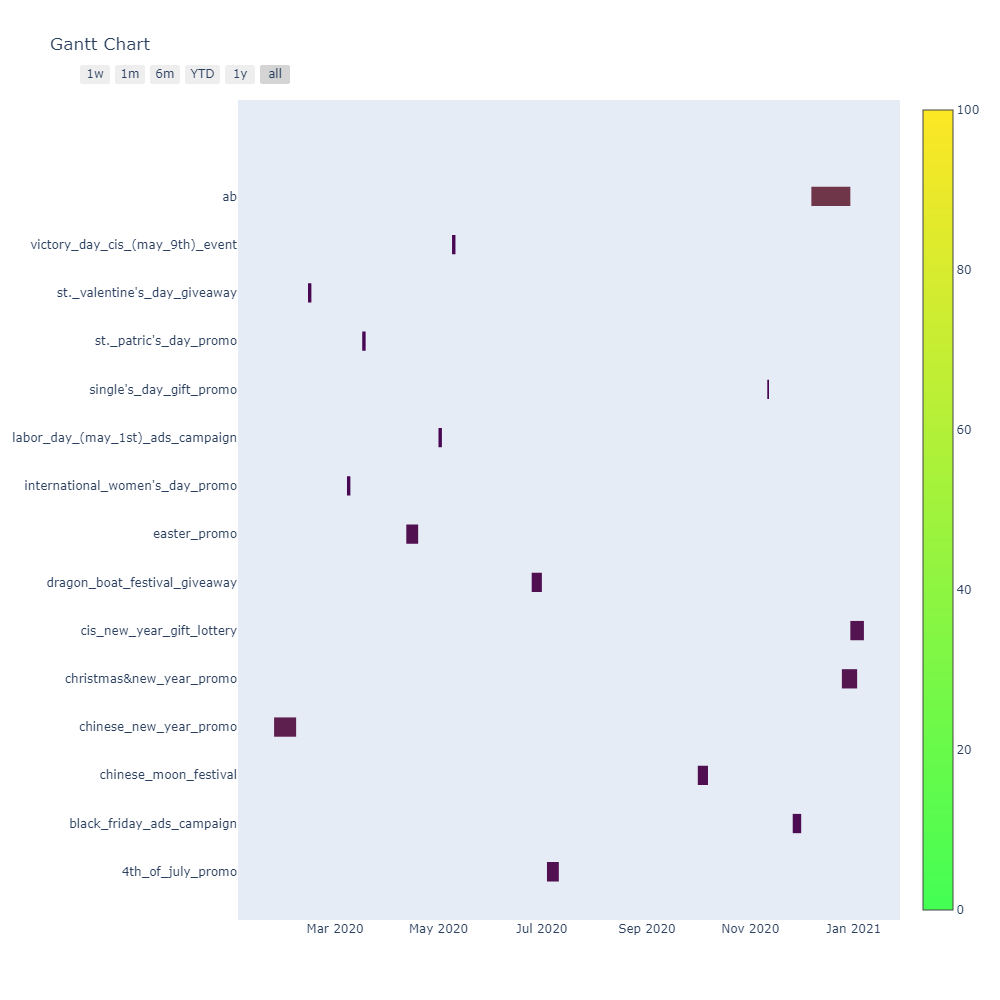

In [29]:
# диаграмма Ганта

# создание списка
df = []
for i in marketing_act.index:
    T = marketing_act.loc[i, 'name']
    S = marketing_act.loc[i, 'promo_start']
    F = marketing_act.loc[i, 'promo_end']
    C = (marketing_act.loc[i, 'dur_days_int'])
    
    df.append(dict(Task=T, Start=S, Finish=F, Complete=C))

df.append(dict(Task="ab", Start='2020-12-07', Finish='2020-12-30', Complete=23))

# построение диаграммы Ганта
fig = ff.create_gantt(df, colors='Viridis', index_col='Complete', show_colorbar=True)
fig.show()

Теперь рассмотрим время проведение АВ теста на диаграмме Ганта

In [30]:
# пересечение активностей
crossing = marketing_act.query('(ab_start <= promo_start <= ab_end) or (ab_start <= promo_end <= ab_end)')
crossing

,name,regions,promo_start,promo_end,duration,ab_start,ab_end,length,dur_days_int
4,christmas&new_year_promo,"eu,_n.america",2020-12-25,2021-01-03,9 days,2020-12-07,2020-12-30,23 days,9
5,cis_new_year_gift_lottery,cis,2020-12-30,2021-01-07,8 days,2020-12-07,2020-12-30,23 days,8


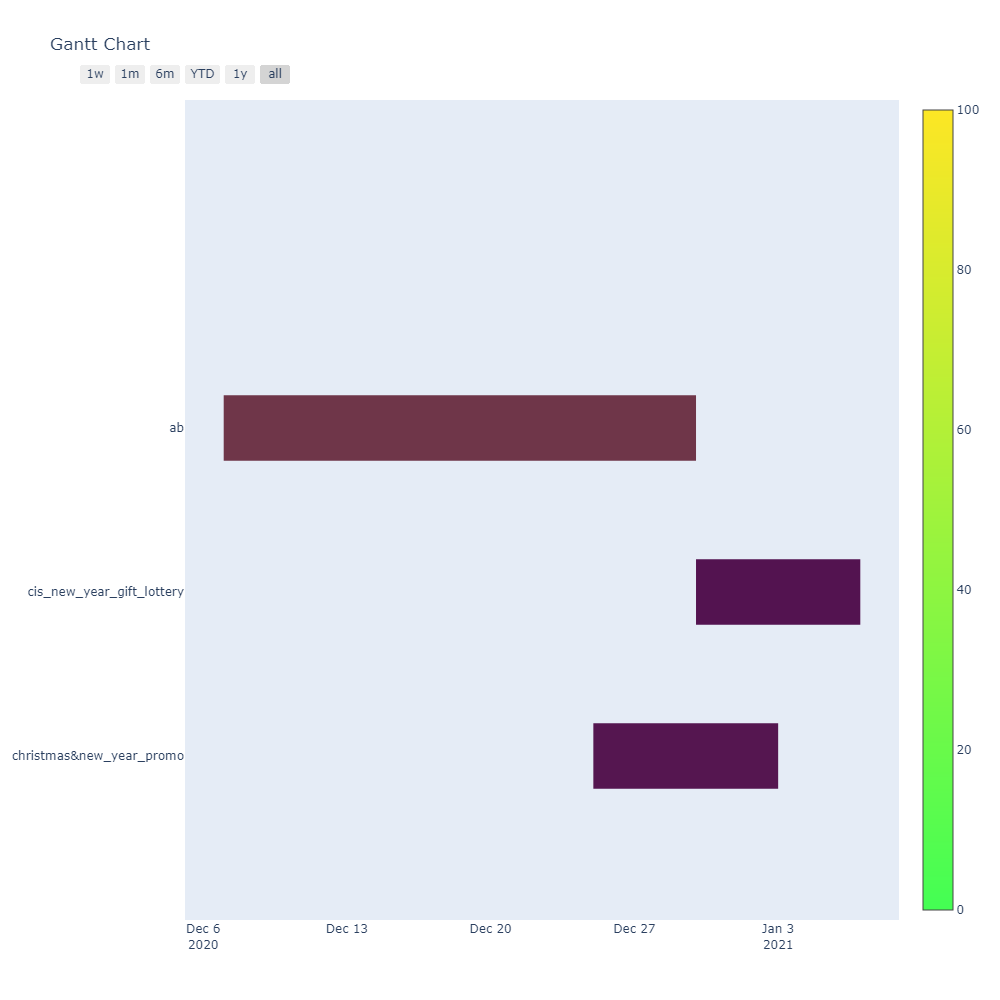

In [31]:
# диаграмма Ганта для АВ теста и попутных маректинговых активностей

df = []
for i in crossing.index:
    T = crossing.loc[i, 'name']
    S = crossing.loc[i, 'promo_start']
    F = crossing.loc[i, 'promo_end']
    C = (crossing.loc[i, 'dur_days_int'])
    
    df.append(dict(Task=T, Start=S, Finish=F, Complete=C))
df.append(dict(Task="ab", Start='2020-12-07', Finish='2020-12-30', Complete=23))

fig = ff.create_gantt(df, colors='Viridis', index_col='Complete', show_colorbar=True)
fig.show()

Имеется пересечение с акцией в НГ. Отфильтруем тех пользователей, участвующих в тестировании, которые пересекаются по времени с этой промо активностью, то есть с 2020-12-25

In [32]:
final_ab = events_ab.query('event_dt < "2020-12-25"')
final_ab.groupby('group', as_index=False).user_id.nunique()

,group,user_id
0,A,2422
1,B,812


Проверим кол-во участников из Европы:

In [33]:
final_ab.head(2)

,user_id,event_dt,event_name,details,group,ab_test
0,D1ABA3E2887B6A73,2020-12-07 14:43:27,purchase,99.99,A,recommender_system_test
2,D1ABA3E2887B6A73,2020-12-07 14:43:29,product_cart,0.00,A,recommender_system_test


In [34]:
reg_users = final_ab.merge(final_ab_new_users, how = 'inner', on = 'user_id').groupby('region', as_index=False).user_id.nunique()
reg_users['reg_share'] = (reg_users.user_id / reg_users.user_id.sum()).map(lambda x: '{:.2%}'.format(x))
reg_users


,region,user_id,reg_share
0,apac,40,1.43%
1,cis,27,0.97%
2,eu,2625,94.09%
3,n.america,98,3.51%


Доля Европы достаточна велика для соответствия требованиям тех.задания, однако кол-во составляет уже менее `50%` от требуемого

In [35]:
print("Кол-во пользщователей в АВ тесте: ", final_ab.user_id.nunique())

Кол-во пользщователей в АВ тесте:  3234


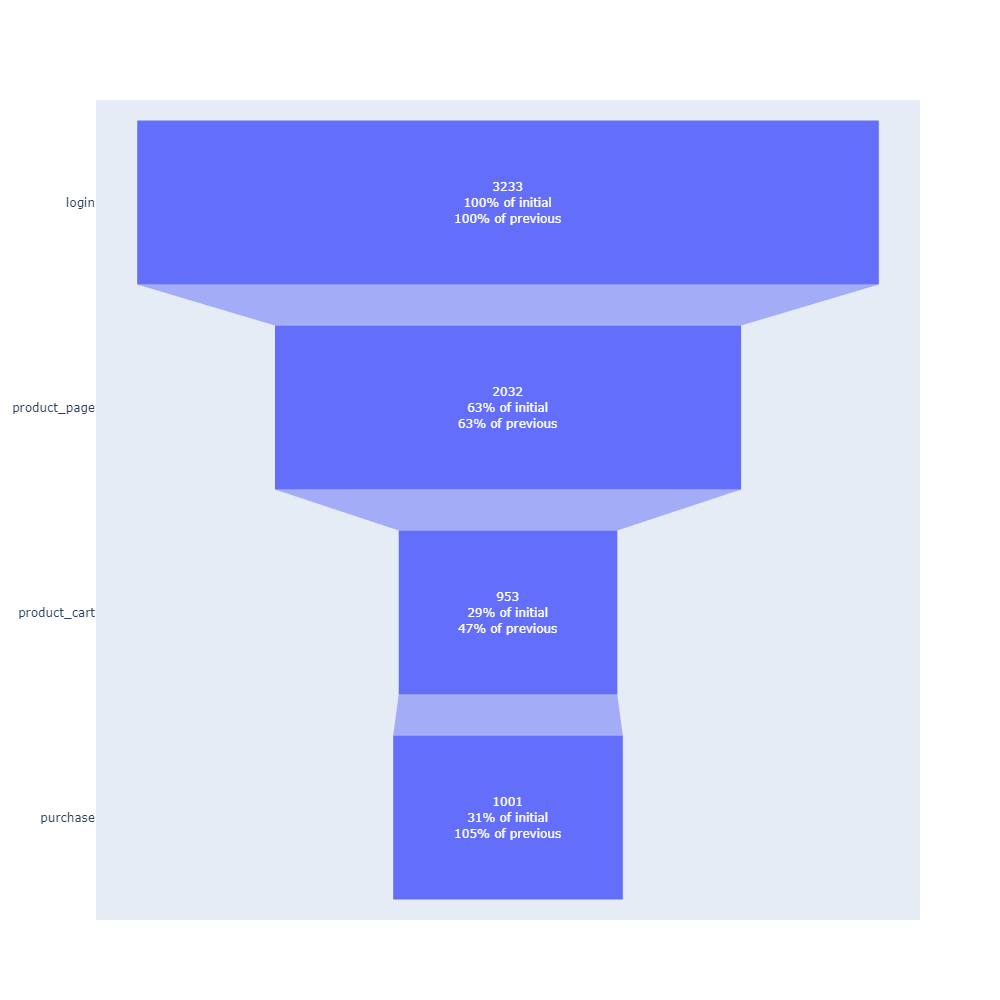

In [36]:
# воронка для двух групп вместе

funnel=final_ab.groupby('event_name',as_index=False).agg({'user_id':'nunique'}).reindex([0,2,1,3])
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['user_id'],
    textinfo = "value+percent initial+percent previous"
    ))
fig.show() 

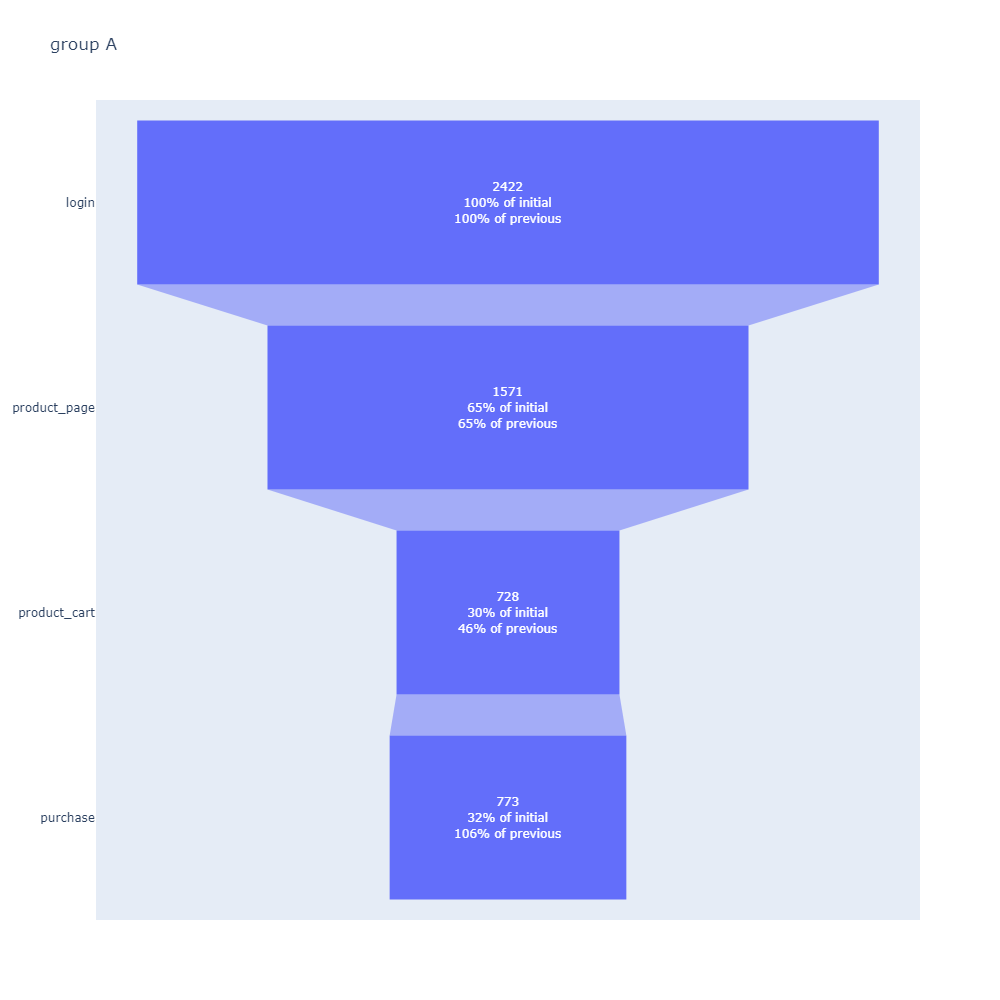

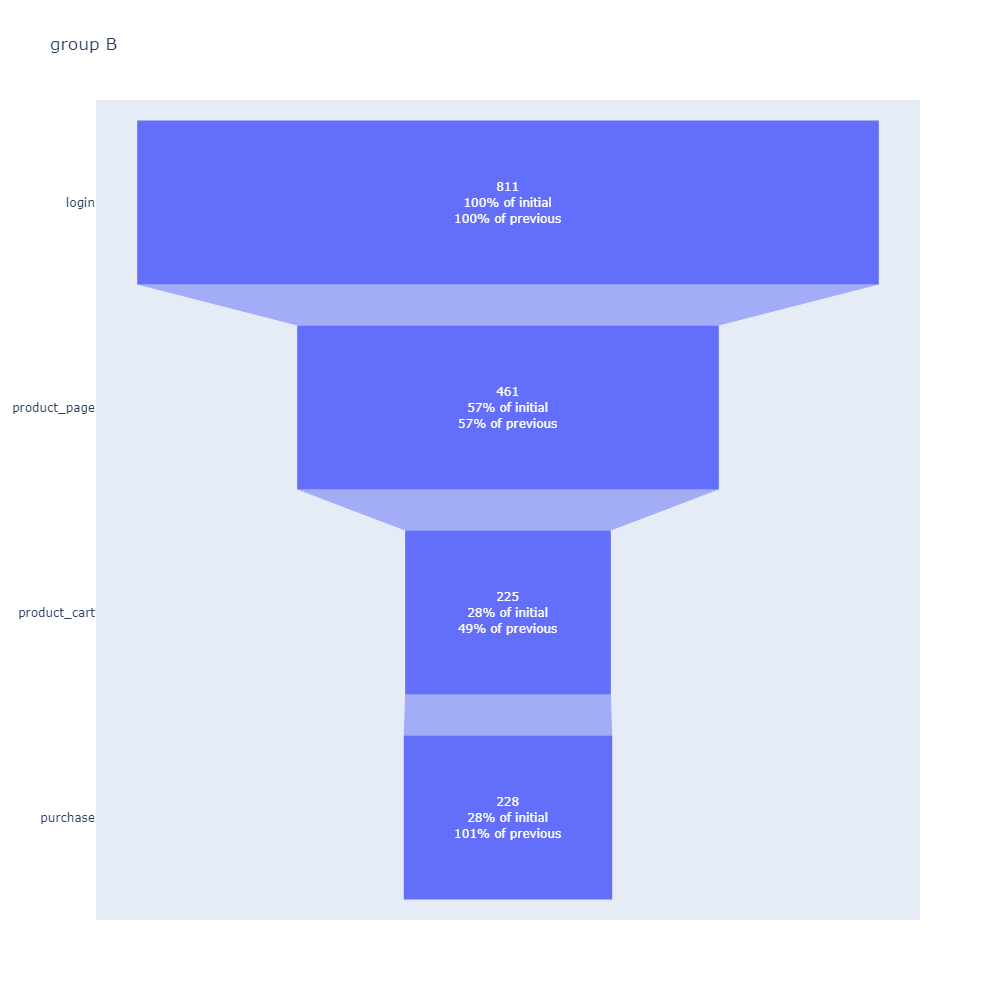

In [37]:
# воронка для каждой из групп

for i in ['A', 'B']:
    funnel=final_ab.query(f'group == @i').groupby('event_name',as_index=False).agg({'user_id':'nunique'}).reindex([0,2,1,3])
    fig = go.Figure(go.Funnel(
        y = funnel['event_name'],
        x = funnel['user_id'],
        textinfo = "value+percent initial+percent previous"        
        ))
    fig.update_layout(
        title = f'group {i}',
        autosize=True)
        
    fig.show() 

In [38]:
group_a = final_ab.query(f'group == "A"').groupby('event_name',as_index=False).agg({'user_id':'nunique'}).reindex([0,2,1,3])
group_b = final_ab.query(f'group == "B"').groupby('event_name',as_index=False).agg({'user_id':'nunique'}).reindex([0,2,1,3])
display(group_b)

,event_name,user_id
0,login,811
2,product_page,461
1,product_cart,225
3,purchase,228


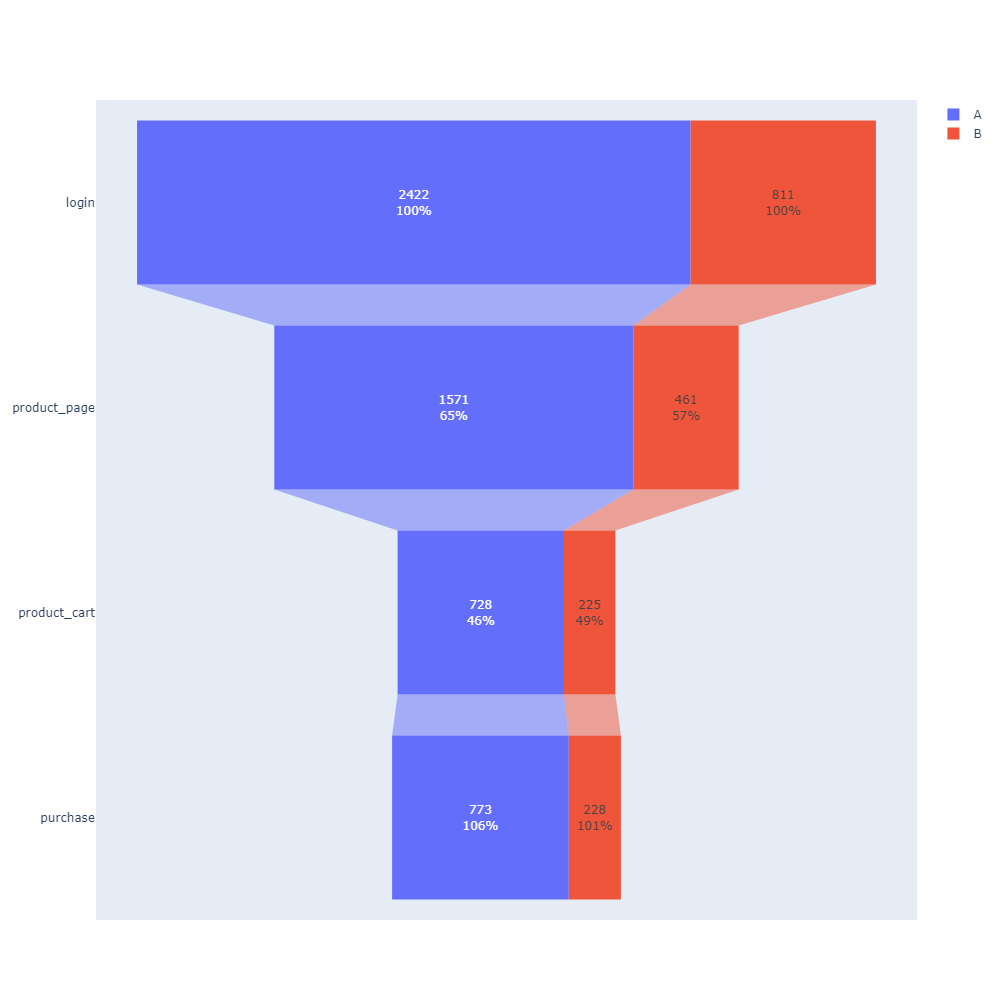

In [39]:
# смежная воронка
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = group_a.event_name,
    x = group_a.user_id,
    textposition = "inside",
    textinfo = "value+percent previous"
    ))

fig.add_trace(go.Funnel(
    name = 'B',
    y = group_b.event_name,
    x = group_b.user_id,
    textposition = "inside",
    textinfo = "value+percent previous"
    ))

fig.show()

Требование тех.задания повышения конверсии не выполнено

In [41]:
for i in ['A', 'B']:
    print('group', i)
    display(round(final_ab.query('group == @i').groupby('user_id').agg({'event_name':'count', 'details':'sum'}).describe(), 3))
    

group A


,event_name,details
count,2422.000,2422.000
mean,6.060,19.814
std,3.424,72.730
min,1.000,0.000
25%,4.000,0.000
50%,6.000,0.000
75%,8.000,9.980
max,24.000,999.980


group B


,event_name,details
count,812.000,812.000
mean,5.297,15.166
std,3.361,61.359
min,1.000,0.000
25%,3.000,0.000
50%,4.000,0.000
75%,6.000,4.990
max,24.000,519.950


Заметно, что большинство пользователей покупает на минимальную сумму

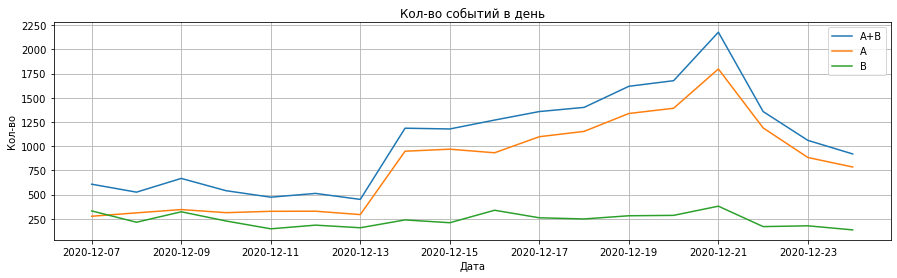

In [42]:
final_ab['date'] = pd.to_datetime(final_ab.event_dt, format='%Y-%m-%d').dt.date

by_date = final_ab.groupby('date', as_index=False).user_id.count()
by_date_a = final_ab.query('group == "A"').groupby('date', as_index=False).user_id.count()
by_date_b = final_ab.query('group == "B"').groupby('date', as_index=False).user_id.count()

plt.rcParams["figure.figsize"] = (15, 4)
sns.lineplot(by_date.date, by_date.user_id, label='A+B')
sns.lineplot(by_date_a.date, by_date_a.user_id, label='A')
sns.lineplot(by_date_b.date, by_date_b.user_id, label='B')

plt.xticks(rotation=0) 
plt.xlabel('Дата')
plt.ylabel('Кол-во')
plt.title('Кол-во событий в день')
plt.grid()
plt.show()

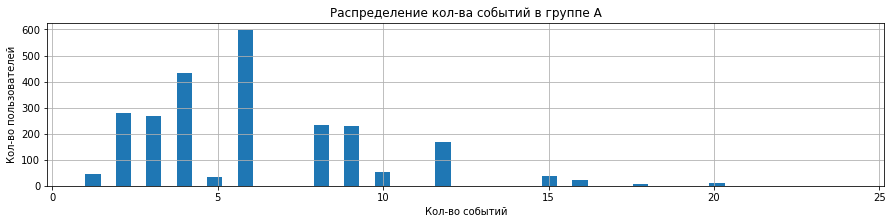

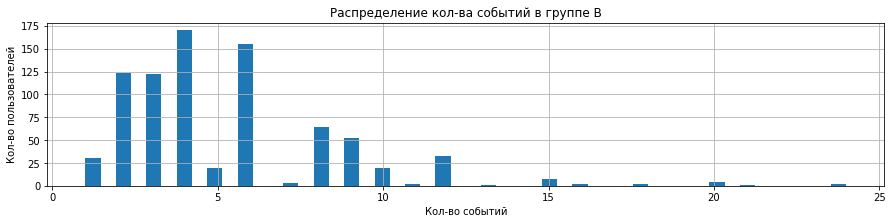

In [43]:
for i in ['A', 'B']:
    plt.rcParams["figure.figsize"] = (15, 3)
    final_ab.query('group == @i').groupby('user_id', as_index = False).event_name.count().hist(bins=50)
    plt.xlabel('Кол-во событий')
    plt.ylabel('Кол-во пользователей')
    plt.title(f"Распределение кол-ва событий в группе {i}")
    plt.show()

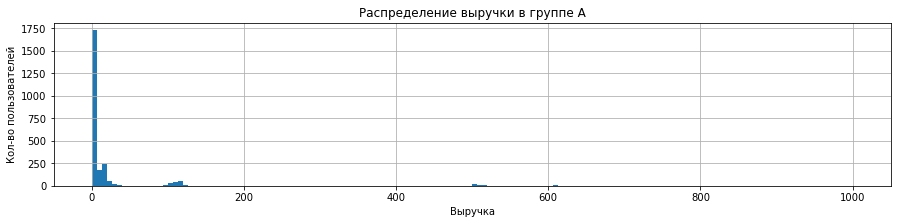

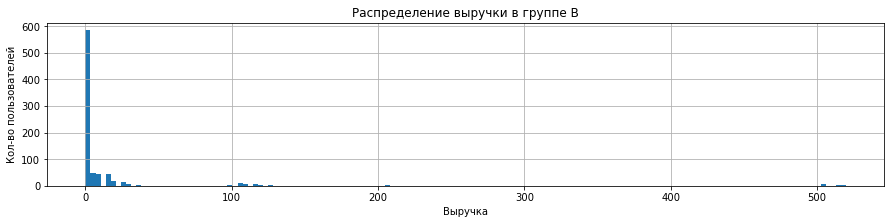

In [44]:
for i in ['A', 'B']:
    plt.rcParams["figure.figsize"] = (15, 3)
    final_ab.query('group == @i').groupby('user_id', as_index = False).details.sum().hist(bins=150)
    plt.xlabel('Выручка')
    plt.ylabel('Кол-во пользователей')
    plt.title(f"Распределение выручки в группе {i}")
    plt.show()

In [45]:
# подготовка данных для отображения
events_by_date = final_ab.groupby(['date', 'group'], as_index=False).event_dt.count()
events_by_date_a = events_by_date.query('group == "A"').reset_index(drop=True)
events_by_date_b = events_by_date.query('group == "B"').reset_index(drop=True)
events_by_date_a = events_by_date_a.rename(columns = {'event_dt':'n_events'})
events_by_date_b = events_by_date_b.rename(columns = {'event_dt':'n_events'})
events_by_date_b.head(2)

,date,group,n_events
0,2020-12-07,B,331
1,2020-12-08,B,214


In [46]:
# подготовка данных для отображения
events_by_date_uua = final_ab.groupby(['date', 'group'], as_index=False).user_id.nunique().query('group == "A"')
events_by_date_uub = final_ab.groupby(['date', 'group'], as_index=False).user_id.nunique().query('group == "B"')
events_by_date_uua = events_by_date_uua.rename(columns = {'user_id':'n_users'}).reset_index(drop=True)
events_by_date_uub = events_by_date_uub.rename(columns = {'user_id':'n_users'}).reset_index(drop=True)

events_by_date_uub.head(2)

,date,group,n_users
0,2020-12-07,B,150
1,2020-12-08,B,103


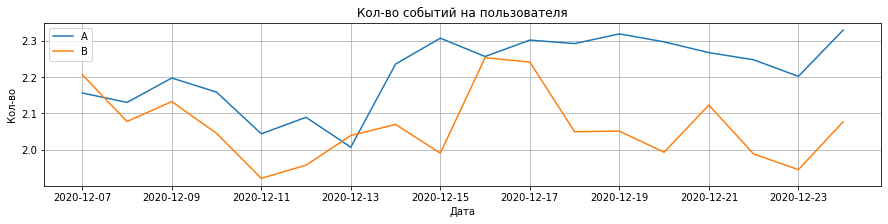

In [47]:
events_by_date_a['events_by_u'] = events_by_date_a.n_events / events_by_date_uua.n_users
events_by_date_b['events_by_u'] = events_by_date_b.n_events / events_by_date_uub.n_users
events_by_date_b

sns.lineplot(events_by_date_a.date, events_by_date_a.events_by_u, label="A")
sns.lineplot(events_by_date_b.date, events_by_date_b.events_by_u, label="B")
# plt.xticks(date_event_sum.date)
plt.xticks(rotation=0) 
plt.xlabel('Дата')
plt.ylabel('Кол-во')
plt.title('Кол-во событий на пользователя')
plt.grid()
plt.show()

### **Вывод**
* Фактическая дата регистрации находится в периоде с 2020-12-07 по 2020-12-23, что не совпадает с техническим заданием (2020-12-07 - 2020-12-21)
* Фактический период проведения теста 2020-12-07 - 2021-01-04
* Период теста пересекается с новогодней промо-акцией, начиная с 2020-12-25. Данные за период с 2020-12-25 не включены в анализ


* Кол-во событий в датах, соответствующих тех.заданию – 50180
* В Европе – 37690, 75,11%
* Для А и В групп кол-во событий составляет 9655 и 8613 соответственно
* Число пользователей А и В групп составляет 2422 и 812 соответственно, что меньше необходимо заявленного в тех.задании  6.000


* Для Европы кол-во АВ тестируемых пользователей составляет 2625 или 94.09%, что меньше необходимо заявленного в тех.задании  6.000, но значительно больше требования в 15% по доли


* В воронке событий login – product_page – purchase – product_card для группы А распределение следующее:
* * Login(2422), product_page(1571, 65% от начального / предыдущего), purchase(773, 32% от начального, 49% от предыдущего), product_cart (728, 30% от начального, 94% от предыдущего)
* Для В:
* * Login(811), product_page(461, 57% от начального / предыдущего), purchase(228, 28% от начального, 49% от предыдущего), product_cart (225, 28% от начального, 99% от предыдущего)


* Событий на пользователя в группе А: 4 и 6 с показателями порядка 440 и 600 соответственно
* Событий на пользователя в группе В: 4 и 6 с показателями порядка 170 и  соответственно


* Выручка на пользователя в группе А распределена вплоть до 1000у.е. с пиком в «0» с кол-вом пользователей порядка 1900
* Выручка на пользователя в группе В распределена вплоть до 500у.е. с пиком в «0» с кол-вом пользователей порядка 620

* Кол-во событий в день на одного пользователя в группе В постоянно ниже, чем в группе А, за исклюючением 7-го и 13-го декабря, где пользователи группы В слегка активнее, и 16-го декабря, где события в среднем на одного пользователя равны в обеих группах.


In [48]:
final_ab_new_users = pd.read_csv("//Keenetic-5974/adata/1 Yandex.Praktikum/Sprint3/12 Final Project/2 AB/Data/final_ab_new_users.csv")
users = final_ab.merge(final_ab_new_users, how = 'right', on = 'user_id').merge(final_ab_participants, on='user_id', how='right')
print("Кол-во пользователей из Европы в тесте: ",
    (users.query('region == "EU" & (ab_test_x == "recommender_system_test")').user_id.nunique() / users.query('region == "EU"').user_id.nunique())*100, \
    "%")

Кол-во пользователей из Европы в тесте:  18.632017651385144 %


## AB тестирование

В АВ тестировании будем рассматривать две группы А и В на предмет статистического различия между ними. Необходимо использовать информацию в соответствии с:
* период событий проведения тестирования
* группировка по группам тестирования

In [49]:
user_groups = final_ab.groupby('group').user_id.nunique()     #кол-во пользователей в группах
user_groups

group
A    2422
B     812
Name: user_id, dtype: int64

In [50]:
event_groups = final_ab.pivot_table(
    index='event_name', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').sort_values(by='A', ascending=False).reset_index()

In [51]:
event_groups['A+B'] = event_groups.A + event_groups.B
event_l_dropped = event_groups.drop(index=0, axis=0)

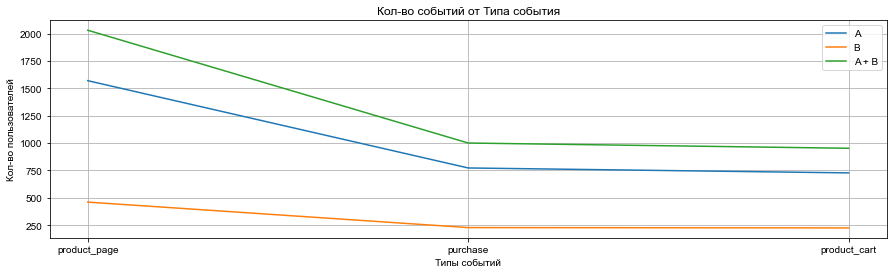

In [52]:
plt.rcParams["figure.figsize"] = (15, 4)
plt.plot(event_l_dropped.event_name, event_l_dropped.A, label='A')
plt.plot(event_l_dropped.event_name, event_l_dropped.B, label='B')
plt.plot(event_l_dropped.event_name, event_l_dropped['A+B'], label='A + B')
plt.legend()
sns.set_style("dark")
plt.title('Кол-во событий от Типа события')
plt.xlabel('Типы событий')
plt.ylabel('Кол-во пользователей')
plt.grid(True)
plt.show()

Как и в воронке, на данном отображения заметно значительное падение на этапе `login - product page"` и `"product page - purchase"`

In [53]:
# ф-ция группового тестирования отличия параметра в паре групп group1 и group2
# с определенным уровнем значимости alpha

def z_test(group1, group2, alpha):
    for i in event_l_dropped.index:
        p1 = event_l_dropped[group1][i] / user_groups[group1] # пропорция успеха в 1-й группе
        p2 = event_l_dropped[group2][i] / user_groups[group2] # пропорция успеха во 2-й группе
        # пропорция успехов в комбинированном датасете:
        p_combined = ((event_l_dropped[group1][i] + event_l_dropped[group2][i]) / 
                      (user_groups[group1] + user_groups[group2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # статистика в ст.отклонениях нормального распределения
        z_value = difference / math.sqrt(p_combined * (1 - p_combined) * 
                                        (1/user_groups[group1] + 1/user_groups[group2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print(f'Для {event_groups["event_name"][i]}\np-value = : {p_value.round(6)}')
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между пропорциями имеется статистически значимая разница")
            
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы (доли) разными")
        print('-'*80)

In [54]:
print('\033[1m'+'Тестирование A и B групп'+'\033[0m', end='\n\n')
z_test("A", "B", 0.01)  #для теста групп без внесенных в процесс изменений уровень значимости строже (ниже 0,05, стандарт - 0,01)

Тестирование A и B групп

Для product_page
p-value = : 3.7e-05
Отвергаем нулевую гипотезу: между пропорциями имеется статистически значимая разница
--------------------------------------------------------------------------------
Для purchase
p-value = : 0.040685
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы (доли) разными
--------------------------------------------------------------------------------
Для product_cart
p-value = : 0.203978
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы (доли) разными
--------------------------------------------------------------------------------


### **Вывод**
* Между группами на стадиях `purchase` и `product_cart` статистической разницы не наблюдается, в то время как на стадии `product_page` показатели даже ухудшились
* Не достигнуты требования увлеичения каждой метрики на 10%

## **Общий вывод**

**Загрузка данных, первичный анализ данных**

* Данные представлены в четырех файлах
* Данные заполнены все на 100%, кроме колонки "details" в файле `final_ab_events`. В данной колонке отсутствуют записи в кол-ве 62740, что составляет 85.75%, то есть уровень заполненности составляет 14.25%
* Дубликаты отсутствуют
* Названия колонок преобразованы в соответствии с требованиями ***snake_style***


**Предобработка данных**

* даты и временные отметки переведены в во временной формат
* пропуски заменены на `0`


**Исследовательский анализ**

* Фактическая дата регистрации находится в периоде с 2020-12-07 по 2020-12-23, что не совпадает с техническим заданием (2020-12-07 - 2020-12-21)
* Фактический период проведения теста 2020-12-07 - 2021-01-04
* Период теста пересекается с новогодней промо-акцией, начиная с 2020-12-25. Данные за период с 2020-12-25 не включены в анализ


* Кол-во событий в датах, соответствующих тех.заданию – 50180
* В Европе – 37690, 75,11%
* Для А и В групп кол-во событий составляет 9655 и 8613 соответственно
* Число пользователей А и В групп составляет 2422 и 812 соответственно, что меньше необходимо заявленного в тех.задании  6.000


* Для Европы кол-во АВ тестируемых пользователей составляет 3040 или 18,63%, что меньше необходимо заявленного в тех.задании  6.000, и немного отличается от требования тех.задания (15%)


* В воронке событий login – product_page – purchase – product_card для группы А распределение следующее:
* * Login(2422), product_page(1571, 65% от начального / предыдущего), purchase(773, 32% от начального, 49% от предыдущего), product_cart (728, 30% от начального, 94% от предыдущего)
* Для В:
* * Login(811), product_page(461, 57% от начального / предыдущего), purchase(228, 28% от начального, 49% от предыдущего), product_cart (225, 28% от начального, 99% от предыдущего)


* Событий на пользователя в группе А: 4 и 6 с показателями порядка 440 и 600 соответственно
* Событий на пользователя в группе В: 4 и 6 с показателями порядка 170 и  соответственно


* Выручка на пользователя в группе А распределена вплоть до 1000у.е. с пиком в «0» с кол-вом пользователей порядка 1900
* Выручка на пользователя в группе В распределена вплоть до 500у.е. с пиком в «0» с кол-вом пользователей порядка 620

* Кол-во событий в день на одного пользователя в группе В постоянно ниже, чем в группе А, за исклюючением 7-го и 13-го декабря, где пользователи группы В слегка активнее, и 16-го декабря, где события в среднем на одного пользователя равны в обеих группах.

**AB тестирование**

* Между группами на стадиях `purchase` и `product_cart` статистической разницы не наблюдается, в то время как на стадии `product_page` показатели даже ухудшились
* Не достигнуты требования увеличения каждой метрики на 10%







## **Итог АВ теста**
1.	Не выполнены пункты технического задания
    * в части сроков проведения исследования (непересечение с другими промо-акциями и др. маркетинговыми активностями)
    * в части периода регистрации новых пользователей для теста
    * в части доли и кол-ва Европейской аудитории 
2.	Не оправданы ожидания об изменении уровня конверсии на стадиях воронки продаж


## **Заключение**
в связи с явными недостатками, выявленными в течение анализа проведения теста и его результатов, а именно:

   * несоответствии теста техническому заданию в части его проведения
   * неоправдавшимся ожиданиям

я бы рекомендовал настроить тест в соответствии с техническим заданием и провести его повтроно, так же соотнесясь с маркетинговыми и промо-активностями